In [58]:
using Plots
using TensorCrossInterpolation, LinearAlgebra
using QuanticsTCI
using QuanticsGrids
using ITensorMPS
using ITensors
using NDTensors
using TCIITensorConversion
using IterativeSolvers
using LinearMaps
using LinearAlgebra
include("src/differential_mpo.jl")

apply_H (generic function with 1 method)

In [59]:
# simulation parameter, starting conditions and boundaries
R = 10
max_bond = 10
cutoff = 1e-12
a = 0.1
dx = 1 / (2^R-1)
delta_t = 0.1 * 2.0^-(R-1)
nu = 1e-5
penalty_coefficient = 2.5e5

function u_1(x, y)
    return exp(-((((x - 0.5)/a)^2/2) + (((y - 0.5)/a)^2)/2))
end

function u_2(x, y)
    return exp(-((((x - 0.5)/a)^2/2) + (((y - 0.5)/a)^2)/2))
end

# QuanticsTCI
qgrid = DiscretizedGrid{2}(R, (0,0), (1,1); includeendpoint = true)
u1q, ranks1, errors1 = quanticscrossinterpolate(Float64, u_1, qgrid; maxbonddim=max_bond)
u2q, ranks2, errors2 = quanticscrossinterpolate(Float64, u_2, qgrid; maxbonddim=max_bond)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 10, DiscretizedGrid{2}(10, (0.0, 0.0), (1.0, 1.0), 2, :fused, true), TensorCrossInterpolation.CachedFunction{Float64, BitIntegers.UInt256} with 15030 entries), [15, 15, 15], [0.041509875322360175, 0.041509875322360175, 0.04264979980384642])

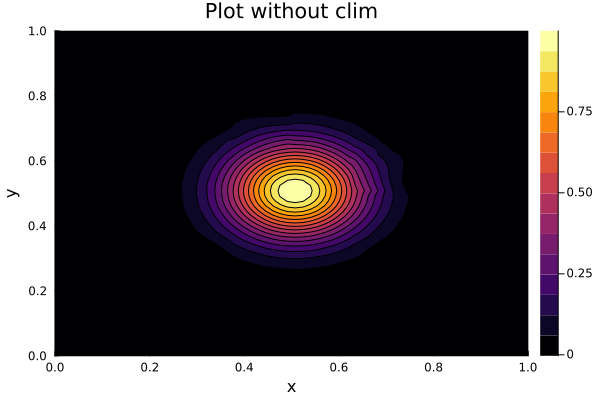

In [60]:
# Convert to ITensorMPS
s = siteinds("Qudit", R, dim=4)
u1 = deepcopy(ITensorMPS.MPS(TensorTrain(u1q.tci), sites=s))
u2 = deepcopy(ITensorMPS.MPS(TensorTrain(u2q.tci), sites=s))
v1 = deepcopy(u1)
v2 = deepcopy(u2)

# Base MPO's
d1x = Diff_1_8_x(dx, s)
d1y = Diff_1_8_y(dx, s)
d2x = Diff_2_8_x(dx, s)
d2y = Diff_2_8_y(dx, s)
dx_dx = apply(d1x, d1x, maxdim=max_bond, cutoff=cutoff)
dy_dy = apply(d1y, d1y, maxdim=max_bond, cutoff=cutoff)
dx_dy = apply(d1x, d1y, maxdim=max_bond, cutoff=cutoff)
del = MPO([delta(s[i], s[i]', s[i]'') for i in 1:length(s)])

plot_mps(u1, R, 6)

In [75]:
center = 2

# orthogonalize mps's
v1 = orthogonalize(v1, center)
v2 = orthogonalize(v2, center)
a1 = orthogonalize(u1, center)
a2 = orthogonalize(u2, center)
b1 = orthogonalize(u1, center)
b2 = orthogonalize(u2, center)

# starting guess for cg
c_vec = get_c_vec(v1, v2, center)

# rhs of equation
beta = make_beta(v1, v2, a1, a2, b1, b2, center, delta_t, nu, d1x, d1y, d2x, d2y, del, max_bond, cutoff)

# linear operator
function A_function(c_vec)
    H_c = apply_H(c_vec, v1, v2, dx_dx, dy_dy, dx_dy, center, max_bond, cutoff)
    return c_vec - penalty_coefficient * delta_t^2 * H_c
end
d = prod(size(v1[center])) + prod(size(v2[center]))
A = FunctionMap{Float64,false}(A_function, d)

320×320 FunctionMap{Float64,false}(A_function; issymmetric=false, ishermitian=false, isposdef=false)

In [76]:
println(c_vec)
# solve system
history = cg!(c_vec, A, beta, abstol=0, reltol=1e-4, verbose=false, maxiter=100, log=true)[2]
println("Center $center: $history")
println(c_vec)
norm(A(c_vec) - beta)

[-90.6508093418078, -3.569323118306809, -1.4515767391120498, -0.05135179749395451, 0.005755262081504307, -0.260136198395841, -0.05330495236455175, -12.878772682428341, 0.16350246668368593, 34.54948827959887, -0.029646502994071167, 0.5158166527496666, 0.17092551631676067, -0.033925098017759676, 34.90081156078816, 0.5271206721969173, 0.0, 0.25411945274539155, 0.1533090337866862, 0.013312747113890981, -0.05263066200553914, -3.5623016306689452, -1.4595976771912376, -89.68378661168623, 0.475850921391511, 29.965213848552537, -0.027344158401358946, 0.07583500741088423, 0.48852493510693507, -0.030000612992805313, 30.172743824444716, 0.0989779839189623, 0.0, -0.5414213061210712, -0.00671953268370103, -0.02059103204566064, -0.021231281330879533, -0.5453415859736109, -0.016498144750741087, 0.0, -1.464616529612265, -78.32208183412207, 0.020459464549538387, -1.4452814533273368, 0.2007855526285356, -0.006674963792338997, 12.043626777430816, 0.20669808280563284, 0.0, -0.0758487832466924, -0.397855679

298.96394900941397

In [77]:
A_mat = Matrix(A)
diff = abs.(A_mat - transpose(A_mat))
println(maximum(diff))
println(sum(diff) / length(diff))
display(eigvals(A_mat))
display(A_mat[1:5,1:5])

1.3170893870953801
0.029749604265676913


320-element Vector{ComplexF64}:
 0.8281587031809889 + 0.0im
 0.8919921847627931 - 0.012597956287573627im
 0.8919921847627931 + 0.012597956287573627im
 0.9067752669947018 - 0.019042379143169797im
 0.9067752669947018 + 0.019042379143169797im
  0.945314107625866 + 0.0im
 0.9572742551420272 + 0.0im
 0.9734510329583601 + 0.0im
  0.981796716615215 - 0.006411474644589166im
  0.981796716615215 + 0.006411474644589166im
                    ⋮
  1225.762193156776 + 0.33769459769911037im
 1225.7654399746198 - 0.3412508366360236im
 1225.7654399746198 + 0.3412508366360236im
 1225.7693406991727 - 0.3412007770872443im
 1225.7693406991727 + 0.3412007770872443im
 1346.9645674440928 + 0.0im
   1346.96856472716 - 8.533488842352365e-5im
   1346.96856472716 + 8.533488842352365e-5im
 1346.9723816926048 + 0.0im

5×5 Matrix{Float64}:
 96.6093   -4.01312   0.0       0.0       0.0
 -4.00574  96.6093    0.0       0.0       0.0
  0.0       0.0      96.6093   -4.01312   0.0
  0.0       0.0      -4.00574  96.6093    0.0
  0.0       0.0       0.0       0.0      96.6093

In [ ]:
function optimize_V(v, a, b, del_t, log=false)
    success = true
    for center in length(v[1]):-1:1
        
        
        v = orthogonalize.(v, center)
        a = orthogonalize.(a, center)
        b = orthogonalize.(b, center)

        # starting guess for cg
        c_vec = get_c_vec(v, center)

        # rhs of equation
        beta = make_beta(v, a, b, center, delta_t, nu, d1, d2, del, max_bond)

        # linear operator
        function A_function(c_vec)
            return c_vec - penalty_coefficient * delta_t^2 * apply_H(c_vec, v, d1, center, max_bond)
        end
        d = sum(length.(array.(getindex.(v, center))))
        A = FunctionMap{Float64,false}(A_function, d)

        # solve system
        if log
            history = cg!(c_vec, A, beta, abstol=1e-6, reltol=0, verbose=false, maxiter=100, log=log)[2]
            println("Center $center: $history")
        else
            cg!(c_vec, A, beta, abstol=1e-3, reltol=0, verbose=false, maxiter=100)
        end

        if norm(A(c_vec) - beta) > 1e-2
            println("Fail!")
            success = false
            break
        end

        # place solution back in the mps
        place_c_vec!(v, c_vec, center)
    end
    return v, success
end

optimize_V (generic function with 2 methods)

In [ ]:
U1, success1 = optimize_V(u, u/4, u, delta_t/6, true)
U2, success2 = optimize_V(u, u/4, 3*U1 + u/4, delta_t/3, true)
U3, success3 = optimize_V(u, u/4, 3/2*U2 + 5/8*u, delta_t/3, true)
U4, success4 = optimize_V(u, u/4, 3*U3 + u/4, delta_t/6, true)

if success1 && success2 && success3 && success4
    println("Timestep done!")
    u = U1 + U2 + U3 + U4
else
    println("Fail! End")
end

Center 10: Not converged after 100 iterations.
Fail!
Center 10: Not converged after 100 iterations.
Fail!
Center 10: Not converged after 100 iterations.
Fail!
Center 10: Not converged after 100 iterations.
Fail!
Fail!


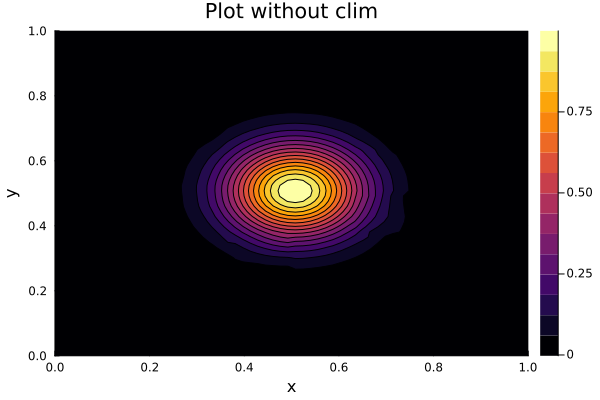

In [7]:
plot_mps(u[1], R, 6)